<a href="https://colab.research.google.com/github/NurhayatYurtaslan/industrial_defect_inspection_demo/blob/main/industrial_defect_inspection_demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/NurhayatYurtaslan/industrial_defect_inspection_demo
%cd /content/industrial_defect_inspection_demo

Cloning into 'industrial_defect_inspection_demo'...
remote: Enumerating objects: 74, done.
remote: Counting objects: 100% (74/74), done.
remote: Compressing objects: 100% (68/68), done.
remote: Total 74 (delta 21), reused 0 (delta 0), pack-reused 0
Receiving objects: 100% (74/74), 26.20 KiB | 1.25 MiB/s, done.
Resolving deltas: 100% (21/21), done.
/content/industrial_defect_inspection_demo


In [2]:
from IPython.display import Image
%matplotlib inline

In [3]:
!wget https://resources.mpi-inf.mpg.de/conference/dagm/2007/Class1_def.zip
!unzip -q Class1_def.zip -d .

--2024-05-25 15:53:34--  https://resources.mpi-inf.mpg.de/conference/dagm/2007/Class1_def.zip
Resolving resources.mpi-inf.mpg.de (resources.mpi-inf.mpg.de)... 139.19.206.46
Connecting to resources.mpi-inf.mpg.de (resources.mpi-inf.mpg.de)|139.19.206.46|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://resources.mpi-inf.mpg.de/conferences/dagm/2007/Class1_def.zip [following]
--2024-05-25 15:53:35--  https://resources.mpi-inf.mpg.de/conferences/dagm/2007/Class1_def.zip
Reusing existing connection to resources.mpi-inf.mpg.de:443.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://conferences.mpi-inf.mpg.de/dagm/2007/Class1_def.zip [following]
--2024-05-25 15:53:35--  https://conferences.mpi-inf.mpg.de/dagm/2007/Class1_def.zip
Resolving conferences.mpi-inf.mpg.de (conferences.mpi-inf.mpg.de)... 139.19.206.169
Connecting to conferences.mpi-inf.mpg.de (conferences.mpi-inf.mpg.de)|139.19.206.169|:443... connected.
H

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline
import os

In [5]:
data_dir = "./Class1_def"

In [6]:
!pip install xmltodict

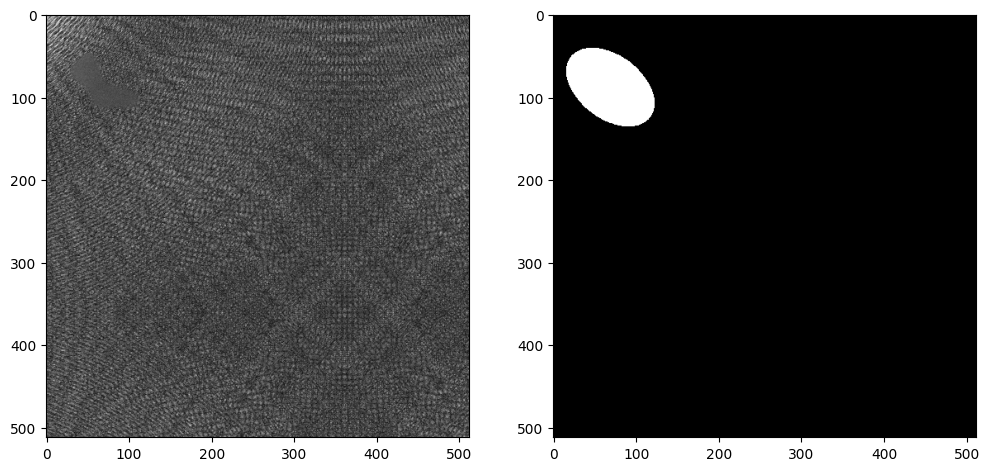

In [7]:
from data import plot_ellipse_seg_test

plot_ellipse_seg_test(os.path.join(data_dir, "1.png"))

In [9]:
from data import load_images_masks

In [10]:
X, y = load_images_masks(data_dir, img_type='png', img_format='gray', resize=(512, 512), ellipse=True)

In [11]:
X.shape

(150, 512, 512, 1)

In [12]:
y.shape

(150, 512, 512, 1)

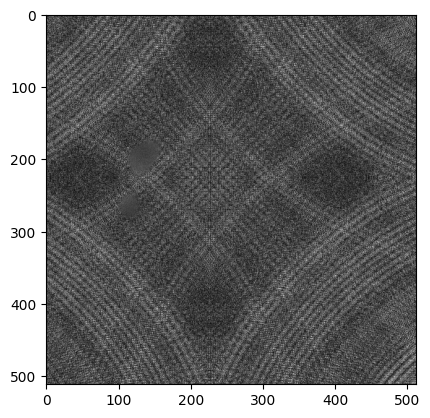

In [70]:
plt.imshow(X[0,:,:,0], cmap='gray')


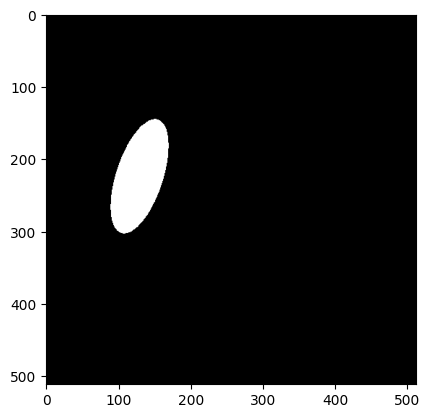

In [16]:
plt.imshow(y[0,:,:,0], cmap='gray')

In [17]:
import sklearn
from sklearn.model_selection import train_test_split

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [19]:
X_train.shape

(105, 512, 512, 1)

In [20]:
X_test.shape

(45, 512, 512, 1)

In [21]:
img_rows = 512
img_cols = 512

In [76]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Lambda, Conv2DTranspose, concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler
from tensorflow.keras import backend as K
from scipy.ndimage.measurements import label
import time
from losses import focal_tversky

<ipython-input-76-5bc389911168>:6: DeprecationWarning: Please use `label` from the `scipy.ndimage` namespace, the `scipy.ndimage.measurements` namespace is deprecated.
  from scipy.ndimage.measurements import label


In [53]:
# Defining a small Unet
# Smaller Unet defined so it fits in memory


def get_small_unet():
    inputs = Input((img_rows, img_cols, 1))
    inputs_norm = Lambda(lambda x: x/127.5 - 1.)
    conv1 = Conv2D(16, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = Conv2D(16, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(32, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool4)
    conv5 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv5)

    up6 = concatenate([Conv2DTranspose(64, kernel_size=(
        2, 2), strides=(2, 2), padding='same')(conv5), conv4], axis=3)
    conv6 = Conv2D(128, (3, 3), activation='relu', padding='same')(up6)
    conv6 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv6)

    up7 = concatenate([Conv2DTranspose(32, kernel_size=(
        2, 2), strides=(2, 2), padding='same')(conv6), conv3], axis=3)
    conv7 = Conv2D(64, (3, 3), activation='relu', padding='same')(up7)
    conv7 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv7)

    up8 = concatenate([Conv2DTranspose(16, kernel_size=(
        2, 2), strides=(2, 2), padding='same')(conv7), conv2], axis=3)
    conv8 = Conv2D(32, (3, 3), activation='relu', padding='same')(up8)
    conv8 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv8)

    up9 = concatenate([Conv2DTranspose(8, kernel_size=(
        2, 2), strides=(2, 2), padding='same')(conv8), conv1], axis=3)
    conv9 = Conv2D(16, (3, 3), activation='relu', padding='same')(up9)
    conv9 = Conv2D(16, (3, 3), activation='relu', padding='same')(conv9)

    conv10 = Conv2D(1, (1, 1), activation='sigmoid')(conv9)

    model = Model(inputs=inputs, outputs=conv10)

    return model

In [24]:
model = get_small_unet()

In [25]:
def smooth_dice_coeff(smooth=1.):

    smooth = float(smooth)

    # IOU or dice coeff calculation
    def IOU_calc(y_true, y_pred):
            y_true_f = K.flatten(y_true)
            y_pred_f = K.flatten(y_pred)
            intersection = K.sum(y_true_f * y_pred_f)

            return 2*(intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

    def IOU_calc_loss(y_true, y_pred):
        return -IOU_calc(y_true, y_pred)
    return IOU_calc, IOU_calc_loss

IOU_calc, IOU_calc_loss = smooth_dice_coeff(0.00001)

In [32]:
import tensorflow as tf

In [99]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), loss=focal_tversky, metrics=[IOU_calc])

In [34]:
history = model.fit(X_train, y_train, batch_size=10, epochs=50, verbose=1, validation_split=0.1)

Epoch 1/50
10/10 [==============================] - 271s 24s/step - loss: 0.9152 - IOU_calc: 0.0725 - val_loss: 0.9167 - val_IOU_calc: 0.0529
Epoch 2/50
10/10 [==============================] - 235s 23s/step - loss: 0.9150 - IOU_calc: 0.0740 - val_loss: 0.9165 - val_IOU_calc: 0.0530
Epoch 3/50
10/10 [==============================] - 245s 25s/step - loss: 0.9149 - IOU_calc: 0.0735 - val_loss: 0.9163 - val_IOU_calc: 0.0532
Epoch 4/50
10/10 [==============================] - 236s 24s/step - loss: 0.9144 - IOU_calc: 0.0738 - val_loss: 0.9159 - val_IOU_calc: 0.0534
Epoch 5/50
10/10 [==============================] - 238s 23s/step - loss: 0.9142 - IOU_calc: 0.0744 - val_loss: 0.9154 - val_IOU_calc: 0.0538
Epoch 6/50
10/10 [==============================] - 240s 24s/step - loss: 0.9134 - IOU_calc: 0.0771 - val_loss: 0.9145 - val_IOU_calc: 0.0545
Epoch 7/50
10/10 [==============================] - 250s 25s/step - loss: 0.9118 - IOU_calc: 0.0757 - val_loss: 0.9121 - val_IOU_calc: 0.0564
Epoch 

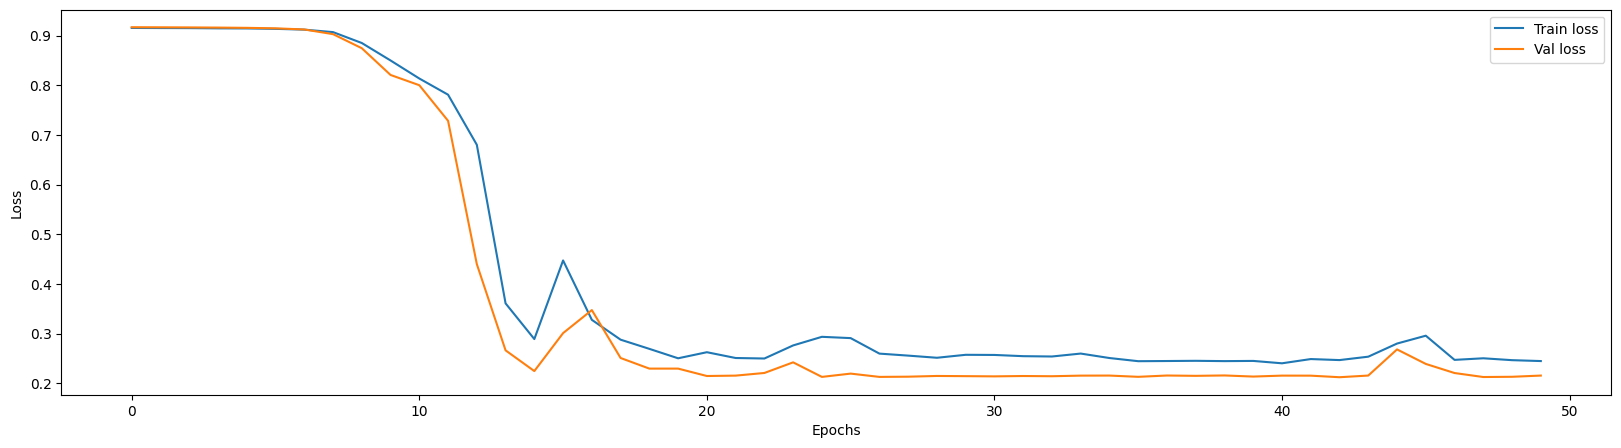

In [104]:
plt.figure(figsize=(20, 5))
plt.plot(history.history['loss'], label='Train loss')
plt.plot(history.history['val_loss'], label='Val loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()


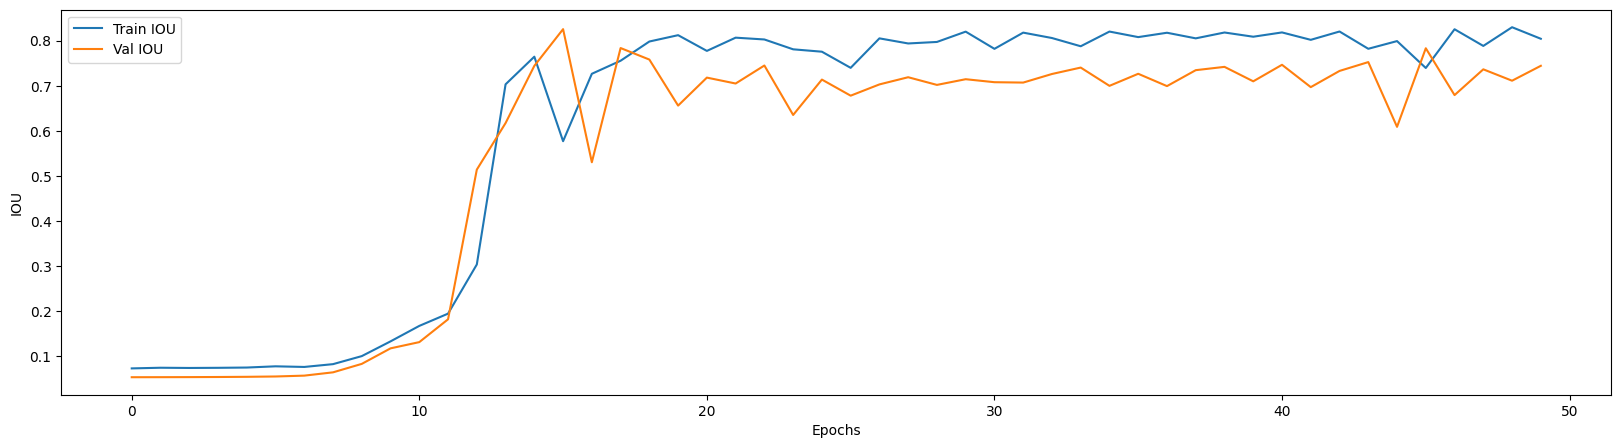

In [106]:
plt.figure(figsize=(20, 5))
plt.plot(history.history['IOU_calc'], label='Train IOU')
plt.plot(history.history['val_IOU_calc'], label='Val IOU')
plt.xlabel('Epochs')
plt.ylabel('IOU')
plt.legend()


In [107]:
predict = model.predict(X_test)

2/2 [==============================] - 32s 7s/step


In [120]:
from tensorflow.keras.optimizers import Adam

model.compile(optimizer=Adam(learning_rate=1e-4), loss=focal_tversky, metrics=[IOU_calc])


In [128]:
import numpy as np
import matplotlib.pyplot as plt

def visualize_prediction(prediction, input_image, true_label):
    plt.figure(figsize=(15, 5))

    # Input image
    plt.subplot(1, 3, 1)
    plt.imshow(input_image, cmap='gray')
    plt.title('Input Image')

    # True label with overlay
    plt.subplot(1, 3, 2)
    plt.imshow(input_image, cmap='gray')
    plt.imshow(true_label, alpha=0.5, cmap='jet')  # Overlay true label
    plt.title('True Label')

    # Prediction with overlay
    plt.subplot(1, 3, 3)
    plt.imshow(input_image, cmap='gray')
    plt.imshow(prediction, alpha=0.5, cmap='jet')  # Overlay prediction
    plt.title('Prediction')

    plt.show()



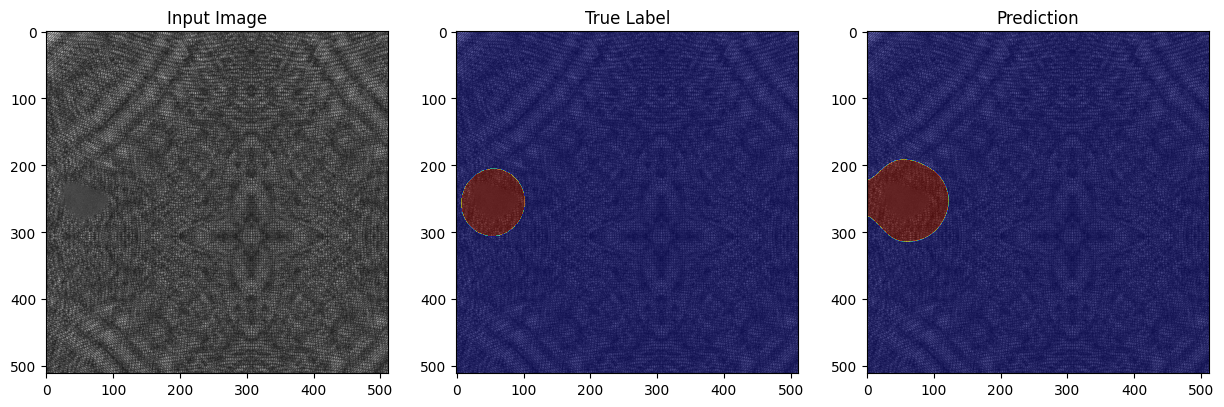

In [129]:
visualize_prediction(predict[1,:,:,0], X_test[1,:,:,0], y_test[1,:,:,0])

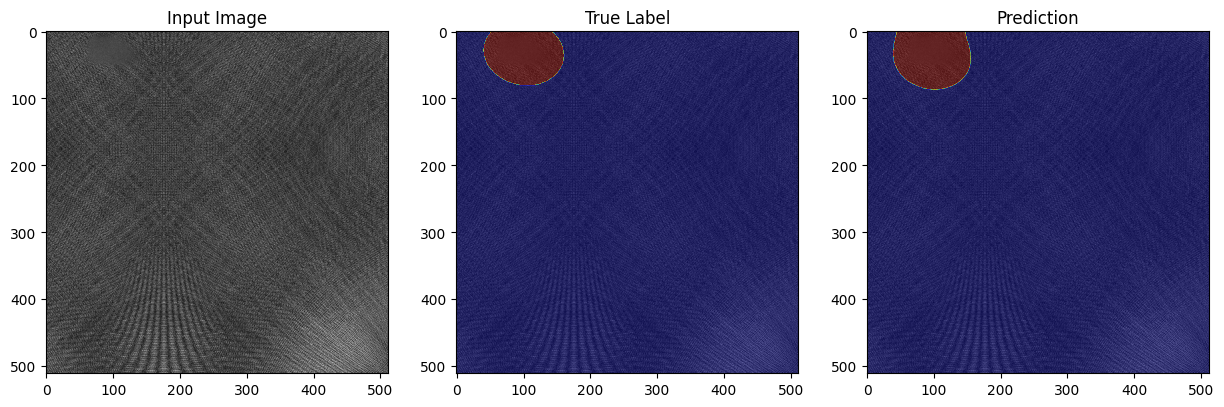

In [130]:
visualize_prediction(predict[2,:,:,0], X_test[2,:,:,0], y_test[2,:,:,0])

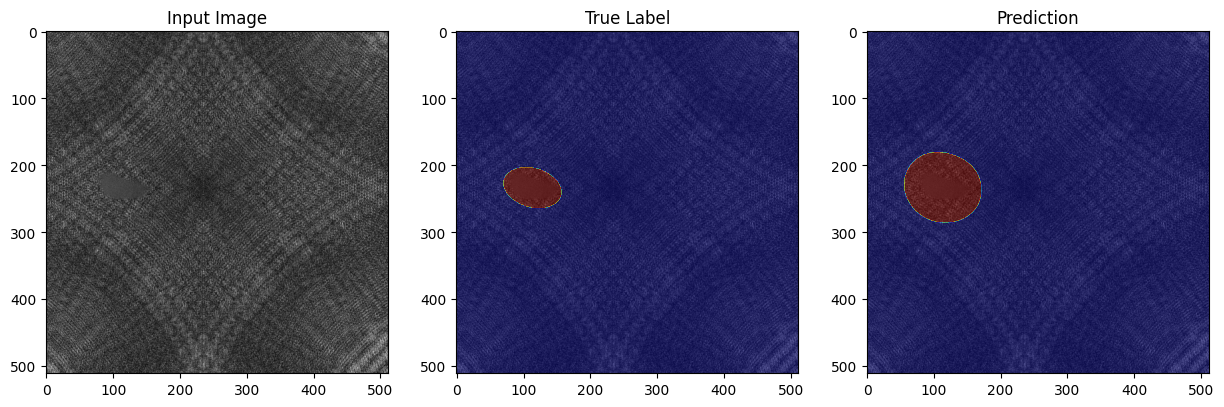

In [133]:
visualize_prediction(predict[3,:,:,0], X_test[3,:,:,0], y_test[3,:,:,0])

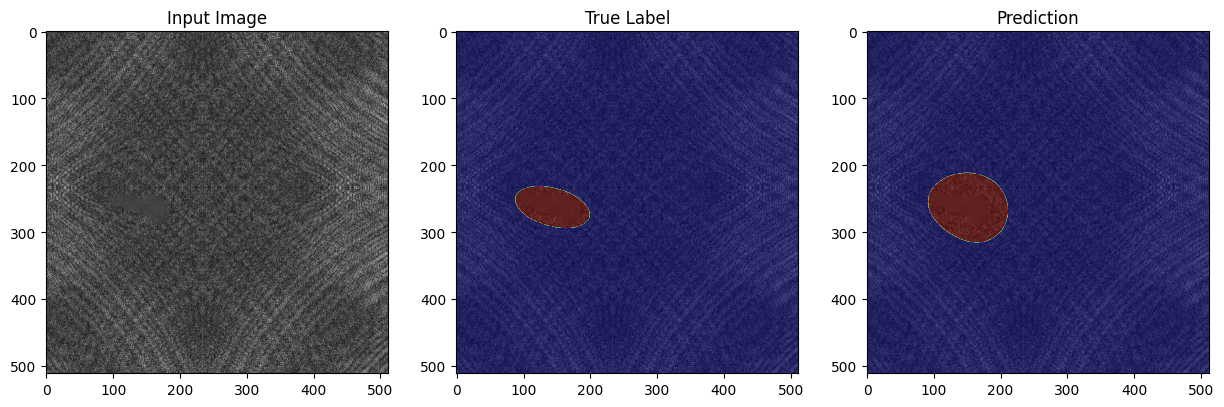

In [135]:
visualize_prediction(predict[4,:,:,0], X_test[4,:,:,0], y_test[4,:,:,0])

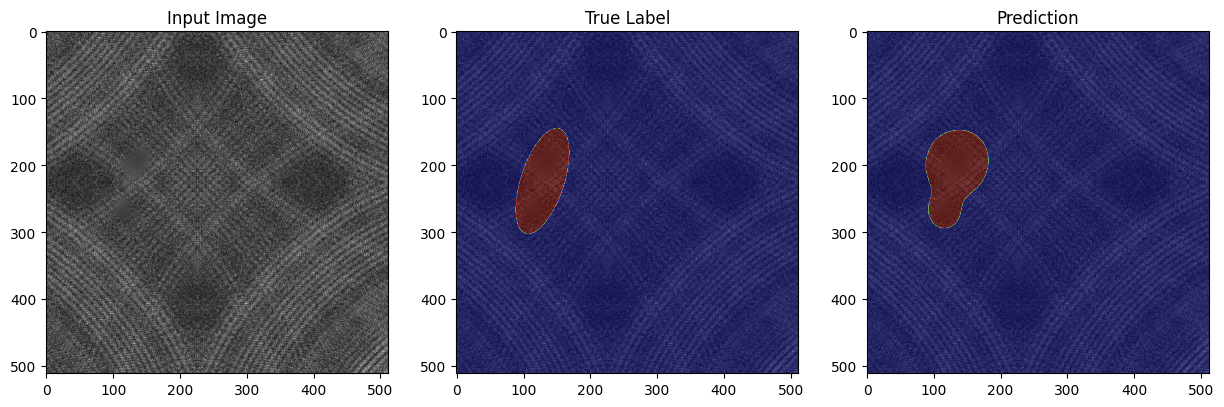

In [134]:
visualize_prediction(predict[5,:,:,0], X_test[5,:,:,0], y_test[5,:,:,0])

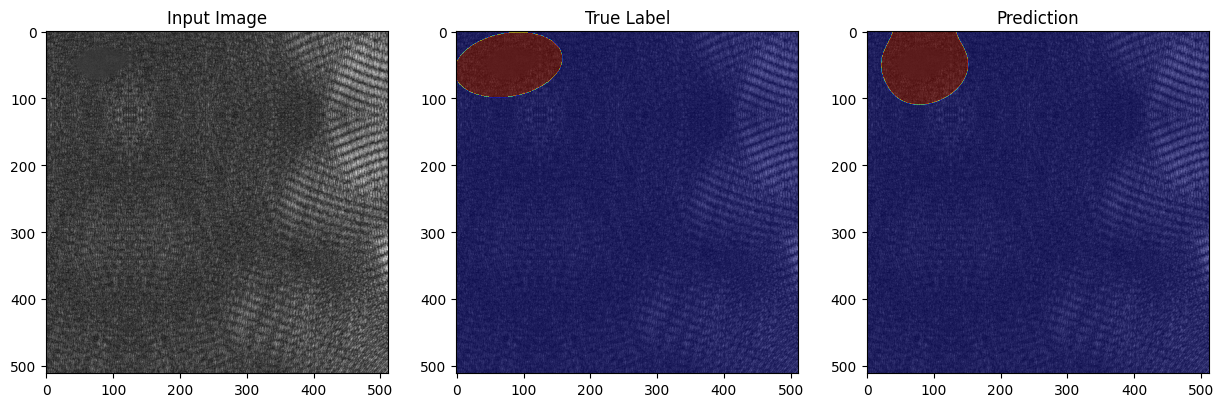

In [136]:
visualize_prediction(predict[6,:,:,0], X_test[6,:,:,0], y_test[6,:,:,0])

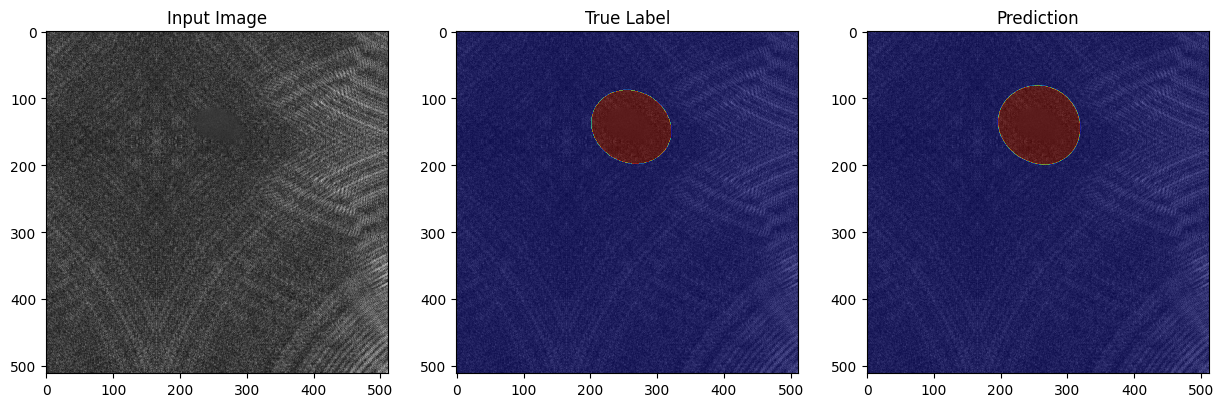

In [137]:
visualize_prediction(predict[7,:,:,0], X_test[7,:,:,0], y_test[7,:,:,0])

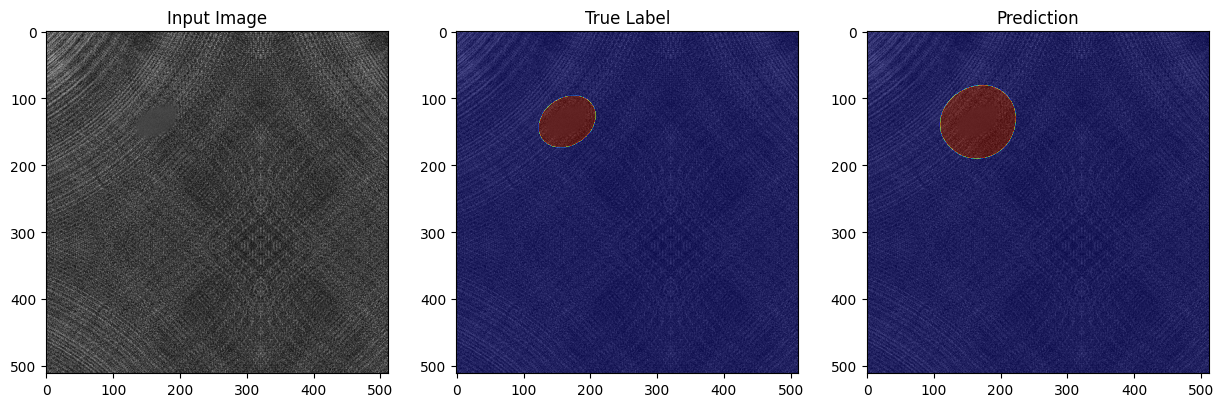

In [138]:
visualize_prediction(predict[8,:,:,0], X_test[8,:,:,0], y_test[8,:,:,0])

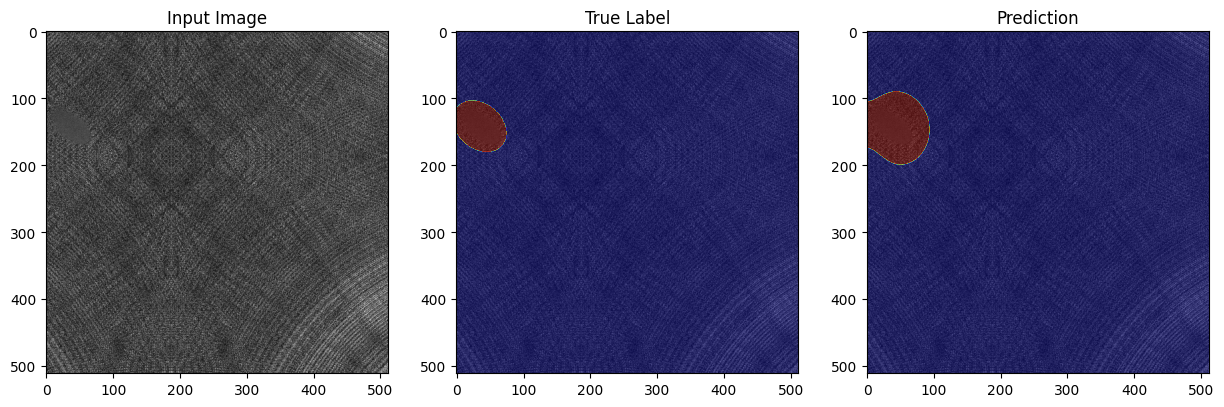

In [139]:
visualize_prediction(predict[9,:,:,0], X_test[9,:,:,0], y_test[9,:,:,0])